In [127]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

In [128]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,XLU.Low,XLU.Close,XLU.Volume,XLU.Adjusted,XLRE.Open,XLRE.High,XLRE.Low,XLRE.Close,XLRE.Volume,XLRE.Adjusted
844,2019-05-13,180.289993,181.259995,178.059998,178.580002,67185800,178.580002,232.009995,232.470001,224.500000,...,57.700001,58.580002,20096300,58.580002,35.869999,36.169998,35.799999,36.110001,3392100,36.110001
845,2019-05-14,179.520004,181.630005,178.860001,180.539993,43360600,180.539993,229.300003,234.500000,228.000000,...,58.080002,58.189999,17609400,58.189999,36.180000,36.389999,36.099998,36.240002,3984400,36.240002
846,2019-05-15,179.350006,183.550003,179.309998,183.089996,40944500,183.089996,229.320007,232.440002,225.250000,...,58.020000,58.090000,14577500,58.090000,36.240002,36.610001,36.099998,36.480000,3478200,36.480000
847,2019-05-16,183.169998,186.070007,182.949997,184.929993,39281200,184.929993,229.490005,231.000000,226.500000,...,57.869999,58.480000,13908300,58.480000,36.480000,36.840000,36.450001,36.689999,2834200,36.689999
848,2019-05-17,183.100006,185.580002,182.880005,183.039993,44669400,183.039993,221.960007,222.240005,208.919998,...,58.139999,58.779999,10477100,58.779999,36.520000,36.709999,36.439999,36.639999,3403200,36.639999


In [129]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data_orig.tail()

,Index,volatilityQQQ,volatilityTSLA,volatilityMSFT,volatilityINTC,volatilityAAPL,volatilityNFLX,volatilityAMZN,volatilityFB,volatilityGOOG,...,volatilityXLB,volatilityXLI,volatilityXLY,volatilityXLP,volatilityXLV,volatilityXLF,volatilityXLK,volatilityXTL,volatilityXLU,volatilityXLRE
844,2019-05-13,0.227654,0.513169,0.269802,0.346441,0.471247,0.324958,0.283485,0.235015,0.217935,...,0.204486,0.201990,0.195013,0.130390,0.160335,0.191713,0.229865,0.226462,0.161205,0.128506
845,2019-05-14,0.246418,0.526124,0.268239,0.367193,0.365657,0.278292,0.295260,0.233604,0.208531,...,0.207505,0.219360,0.208065,0.117154,0.165486,0.203228,0.263019,0.251037,0.154980,0.129728
846,2019-05-15,0.267037,0.457982,0.268356,0.385485,0.387684,0.339966,0.315566,0.309336,0.311047,...,0.207547,0.220494,0.214447,0.124270,0.164090,0.201220,0.277943,0.257279,0.154745,0.133600
847,2019-05-16,0.255270,0.347390,0.272957,0.331132,0.365942,0.332683,0.276670,0.292490,0.299280,...,0.217383,0.214247,0.209255,0.124754,0.164555,0.203585,0.277461,0.227552,0.156189,0.132117
848,2019-05-17,0.257535,0.485160,0.273593,0.330290,0.366657,0.330412,0.291928,0.292859,0.306577,...,0.208028,0.215737,0.210142,0.126243,0.159069,0.203535,0.277591,0.228449,0.153681,0.129404


In [130]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .rename(columns={'Index_x':'Index'})

In [131]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [132]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [133]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .fillna(-1)

In [134]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [135]:
list(data_orig.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [139]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if (('Open' in i[1]) or ("volatility" in i[1]))])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'BABA': 193,
 'BP': 199,
 'BUD': 205,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'FB': 43,
 'GLD': 181,
 'GLW': 211,
 'GOOG': 49,
 'HD': 157,
 'INTC': 19,
 'JNJ': 109,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'NFLX': 31,
 'NVDA': 133,
 'PANW': 127,
 'PFE': 217,
 'PG': 103,
 'QQQ': 1,
 'RHT': 139,
 'SBUX': 79,
 'SFIX': 223,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 229,
 'T': 235,
 'TGT': 91,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 241,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85,
 'XLB': 253,
 'XLE': 247,
 'XLF': 283,
 'XLI': 259,
 'XLK': 289,
 'XLP': 271,
 'XLRE': 307,
 'XLU': 301,
 'XLV': 277,
 'XLY': 265,
 'XTL': 295,
 'volatilityAAPL': 317,
 'volatilityAMD': 325,
 'volatilityAMZN': 319,
 'volatilityBABA': 345,
 'volatilityBP': 346,
 'volatilityBUD': 347,
 'volatilityDATA': 324,
 'volatilityDIS': 338,
 'volatilityDUK': 340,
 'volatilityFB': 320,
 'volatilityGLD': 343,
 'volatilityGLW': 348,
 'volatilityGOOG': 321,
 'volatilityHD': 339,
 'volatility

In [141]:
days_lookback = 1
pct_df = data_orig.iloc[:,1:].shift(days_lookback).fillna(-1)
pct_df

,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,...,MEHOINUSA672N,PCU33443344,MPU9900063,IPMAN,SP500,FEDFUNDS,UNRATE,T10Y2Y,DATE,CBBTCUSD
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
1,109.449997,109.599998,108.120003,109.500000,50807600.0,106.223091,230.720001,231.380005,219.000000,223.410004,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
2,110.040001,110.180000,108.800003,109.309998,38795200.0,106.038773,226.360001,226.889999,220.000000,223.429993,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
3,107.410004,108.889999,107.410004,108.260002,41891100.0,105.020172,220.000000,220.050003,215.979996,219.039993,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
4,105.949997,107.290001,104.809998,104.870003,61386300.0,101.731651,214.190002,218.440002,213.669998,215.649994,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
5,105.629997,106.290001,103.900002,104.010002,69344000.0,100.897369,217.860001,220.440002,210.770004,211.000000,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
6,104.750000,105.059998,102.730003,104.330002,49767900.0,101.207802,214.009995,214.449997,203.000000,207.850006,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
7,105.330002,106.080002,104.080002,105.540001,46734200.0,102.381592,211.600006,213.740005,205.309998,209.970001,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
8,105.970001,106.230003,101.739998,101.900002,69870700.0,98.850510,212.009995,212.649994,200.000000,200.309998,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000
9,102.300003,104.980003,100.669998,104.070000,78445700.0,100.955582,202.210007,210.000000,193.380005,206.179993,...,-1.0,-1.0,-1.0,-1.000000,-1.00000,-1.00,-1.0,-1.000000,-1,-1.000000


In [142]:
data_orig.drop("DATE", axis=1, inplace=True)
pct_df.drop("DATE", axis=1, inplace=True)
data_orig.drop("Index", axis=1, inplace=True)
pct_df.drop("Index", axis=1, inplace=True)

KeyError: "['Index'] not found in axis"

In [143]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
inv_map

{'AAPL.Open': 4,
 'AMD.Open': 12,
 'AMZN.Open': 6,
 'BABA.Open': 32,
 'BP.Open': 33,
 'BUD.Open': 34,
 'DATA.Open': 11,
 'DIS.Open': 25,
 'DUK.Open': 27,
 'FB.Open': 7,
 'GLD.Open': 30,
 'GLW.Open': 35,
 'GOOG.Open': 8,
 'HD.Open': 26,
 'INTC.Open': 3,
 'JNJ.Open': 18,
 'JWN.Open': 16,
 'KO.Open': 19,
 'MSFT.Open': 2,
 'NFLX.Open': 5,
 'NVDA.Open': 22,
 'PANW.Open': 21,
 'PFE.Open': 36,
 'PG.Open': 17,
 'QQQ.Open': 0,
 'RHT.Open': 23,
 'SBUX.Open': 13,
 'SFIX.Open': 37,
 'SLV.Open': 31,
 'SPOT.Open': 28,
 'SQ.Open': 9,
 'STX.Open': 38,
 'T.Open': 39,
 'TGT.Open': 15,
 'TSLA.Open': 1,
 'TWTR.Open': 10,
 'USO.Open': 24,
 'V.Open': 40,
 'VRSN.Open': 20,
 'WDC.Open': 29,
 'WMT.Open': 14,
 'XLB.Open': 42,
 'XLE.Open': 41,
 'XLF.Open': 47,
 'XLI.Open': 43,
 'XLK.Open': 48,
 'XLP.Open': 45,
 'XLRE.Open': 51,
 'XLU.Open': 50,
 'XLV.Open': 46,
 'XLY.Open': 44,
 'XTL.Open': 49,
 'volatilityAAPL.Open': 56,
 'volatilityAMD.Open': 64,
 'volatilityAMZN.Open': 58,
 'volatilityBABA.Open': 84,
 'volati

In [144]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig)

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)
pctdf_mat = scaler.transform(pct_df)

In [145]:
seq_len = 90 # days to use for prediction
data = np.array((data_mat))

In [146]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [147]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = pctdf_mat[:int(row)] # Needs to be N-day shift
x_test = result[int(row):, :]
y_test = pctdf_mat[int(row):]  # Needs to be N-day shift

[x_train, y_train, x_test, y_test]

[array([[[0.56821961, 0.56818919, 0.56815899, ..., 0.6512111 ,
          0.65047189, 0.64954524],
         [0.712434  , 0.71249126, 0.71254903, ..., 0.72957241,
          0.72798834, 0.72622285],
         [0.61194859, 0.61196841, 0.61198845, ..., 0.69358845,
          0.69257468, 0.69137544],
         ...,
         [0.83355733, 0.83356161, 0.83356585, ..., 0.69474866,
          0.69255308, 0.69034115],
         [0.79816307, 0.7981943 , 0.79822581, ..., 0.71409114,
          0.71206485, 0.71002101],
         [0.70894149, 0.70903058, 0.70912032, ..., 0.75463359,
          0.75304215, 0.75143007]],
 
        [[0.712434  , 0.71249126, 0.71254903, ..., 0.72957241,
          0.72798834, 0.72622285],
         [0.61194859, 0.61196841, 0.61198845, ..., 0.69358845,
          0.69257468, 0.69137544],
         [0.45104767, 0.45109662, 0.451146  , ..., 0.70696443,
          0.70679381, 0.70643172],
         ...,
         [0.79816307, 0.7981943 , 0.79822581, ..., 0.71409114,
          0.71206485, 0.

In [148]:
LAYERS = 30
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(
    output_dim=y_train.shape[1]))
model.add(Activation('linear'))

start = time.time()
# adam = Adam(lr=0.1)
model.compile(loss='mse', optimizer="adam")
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 389..., units=30)`
  import sys


compilation time :  0.019010066986083984


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=389)`
  app.launch_new_instance()


In [149]:
MODELNAME = 'multiplemodeltest_medusa'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [150]:
VALIDATIONSIZE = 0.10
EPOCHS = 500
# model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=1024,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save],
    shuffle=True)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 613 samples, validate on 69 samples
Epoch 1/500
613/613 [==============================] - 4s 7ms/step - loss: 1.1038 - val_loss: 1.0803
Epoch 2/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0902 - val_loss: 1.0517
Epoch 3/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0801 - val_loss: 1.0466
Epoch 4/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0684 - val_loss: 1.0566
Epoch 5/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0520 - val_loss: 1.0915
Epoch 6/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0714 - val_loss: 1.0000
Epoch 7/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0352 - val_loss: 0.9737
Epoch 8/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0204 - val_loss: 0.9970
Epoch 9/500
613/613 [==============================] - 1s 2ms/step - loss: 1.0290 - val_loss: 0.9772
Epoch 10/500
613/613 [========================

In [151]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [152]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

In [153]:
# ticker_lookup["AAPL"]
list(data_orig.columns)
# [i[ticker_lookup["AAPL"]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))]

['QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 'DATA.Low',

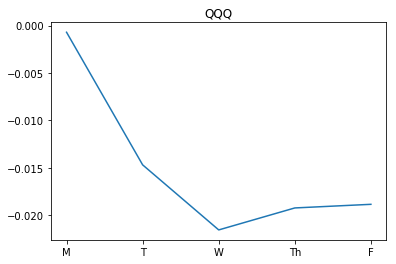

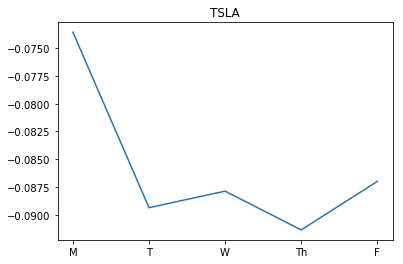

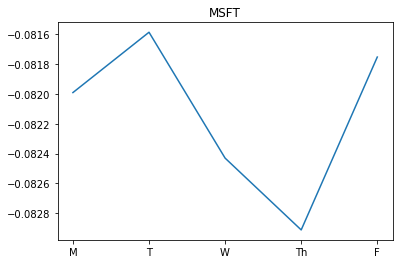

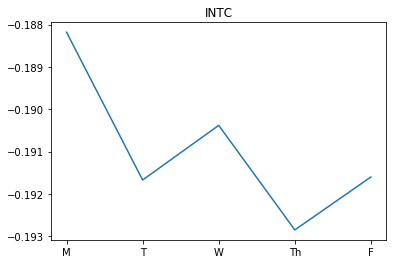

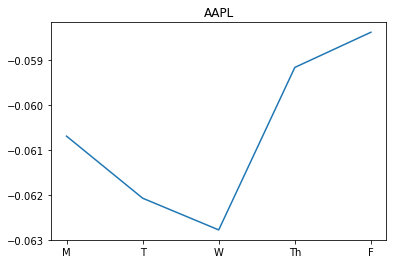

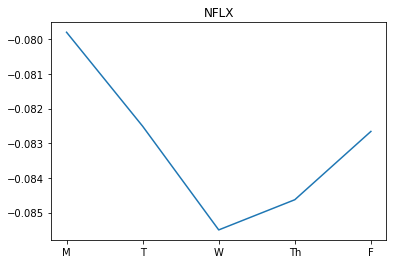

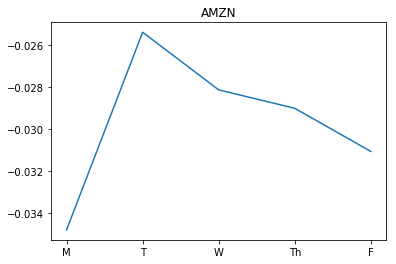

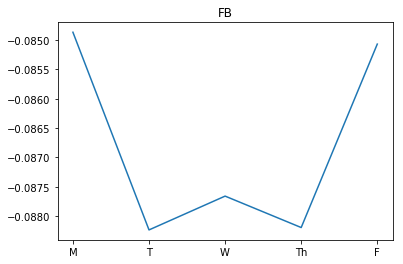

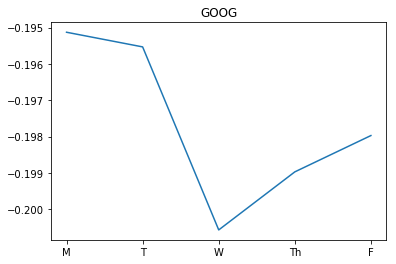

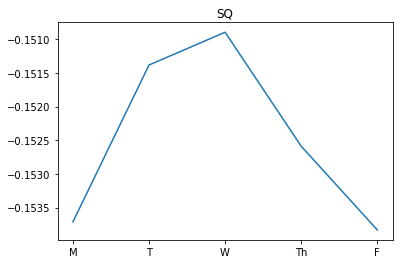

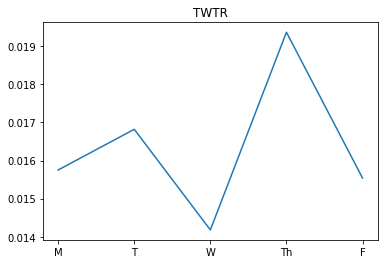

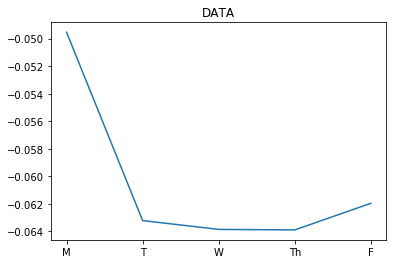

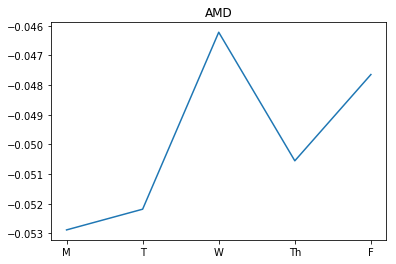

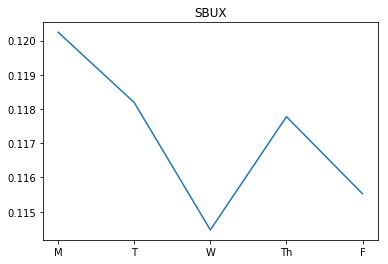

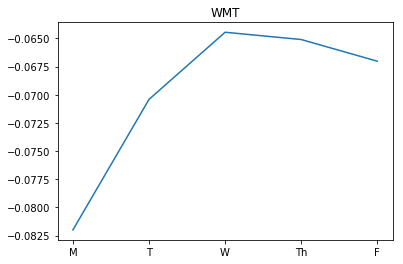

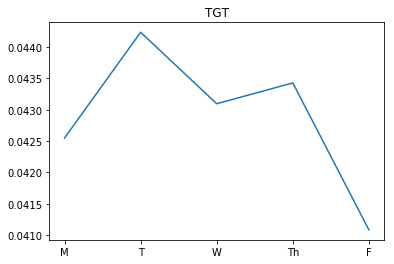

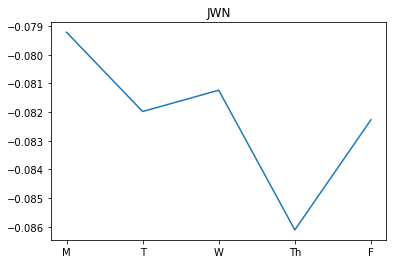

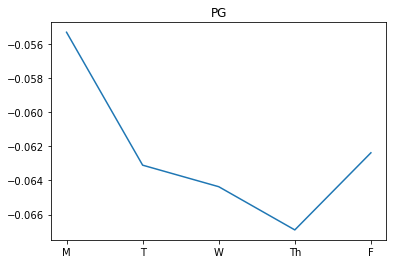

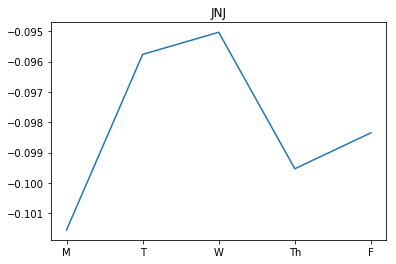

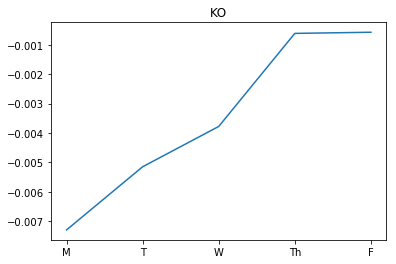

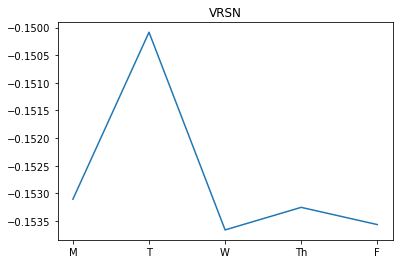

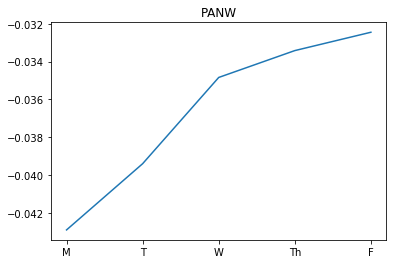

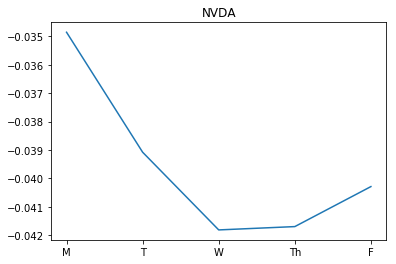

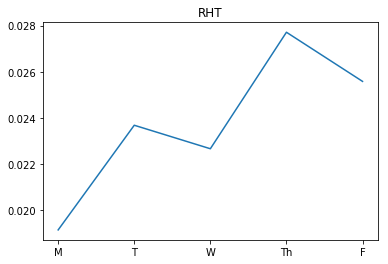

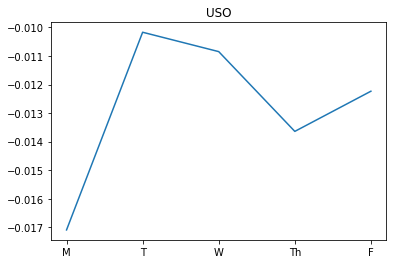

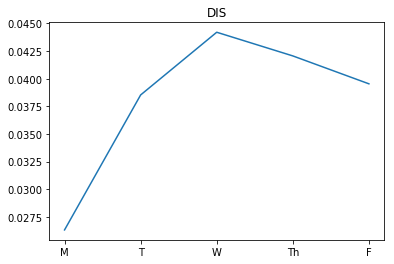

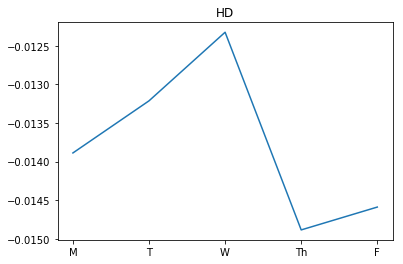

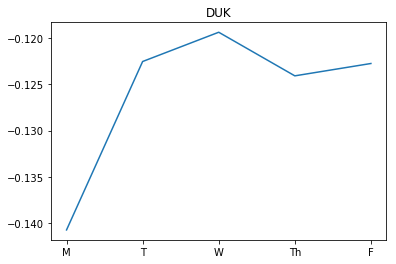

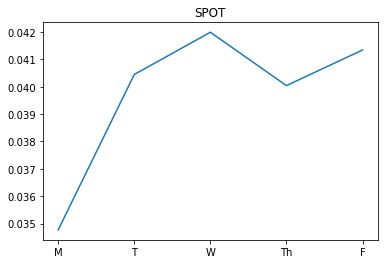

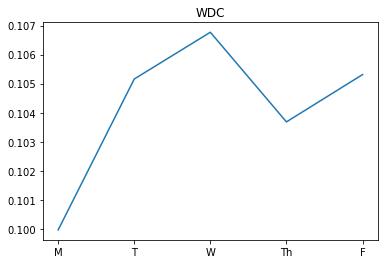

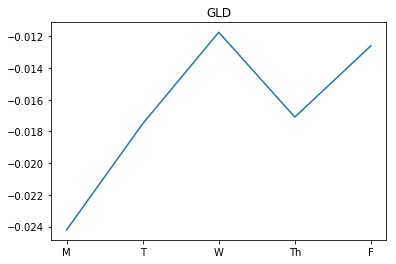

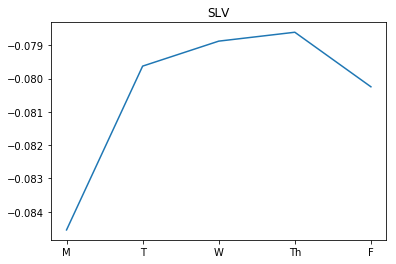

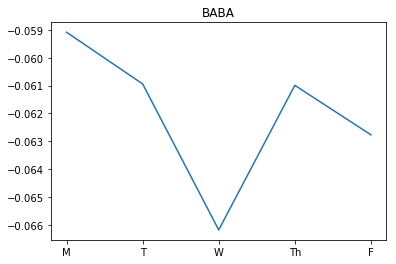

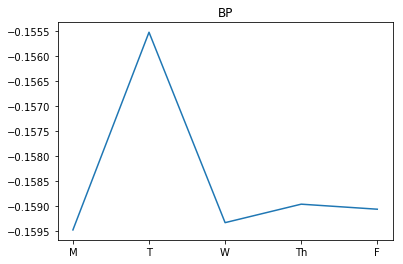

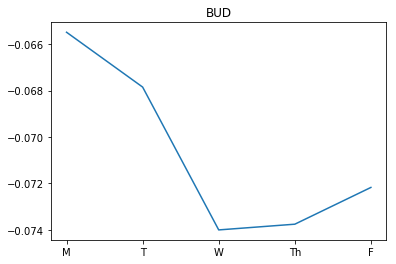

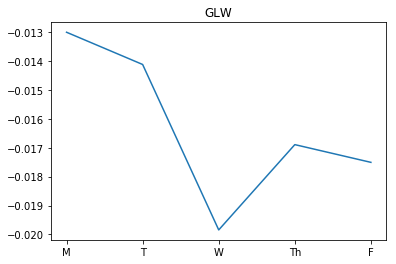

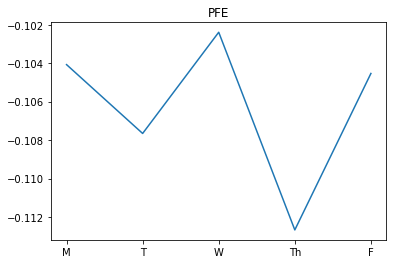

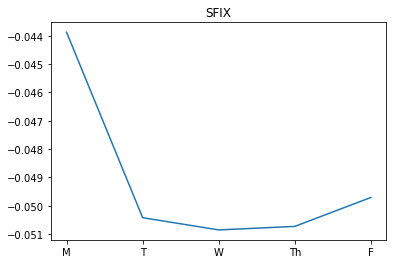

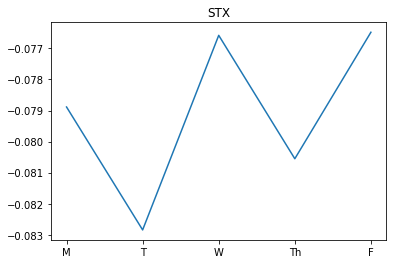

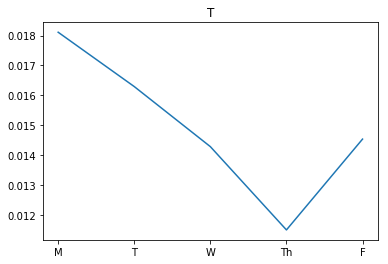

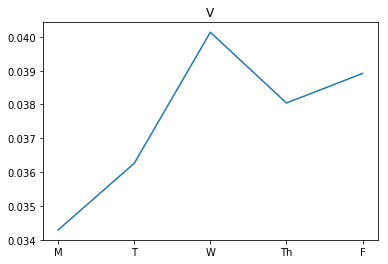

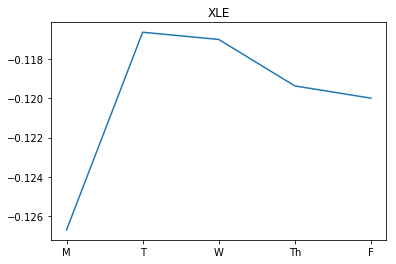

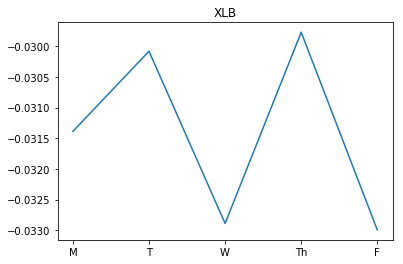

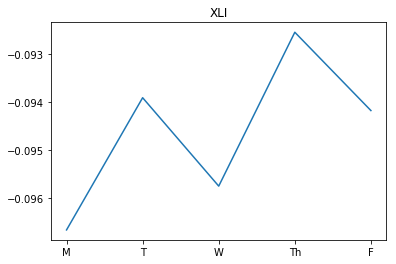

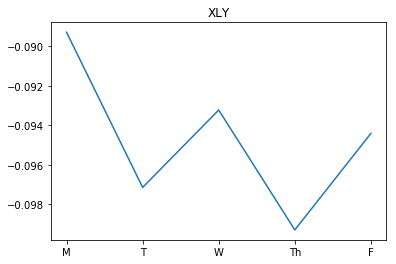

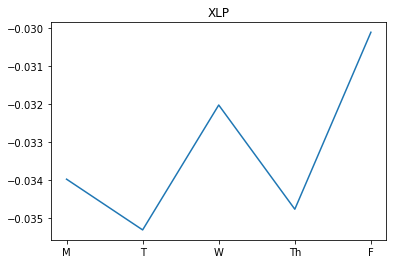

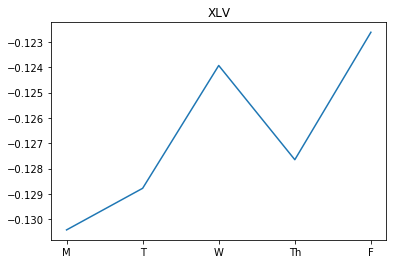

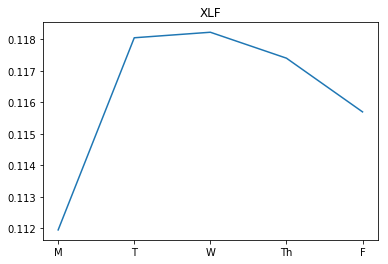

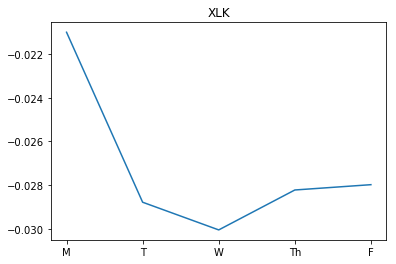

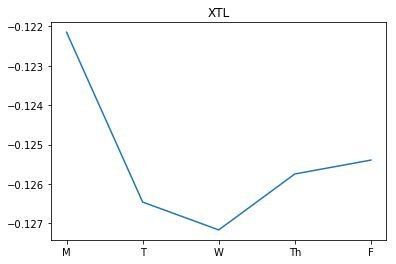

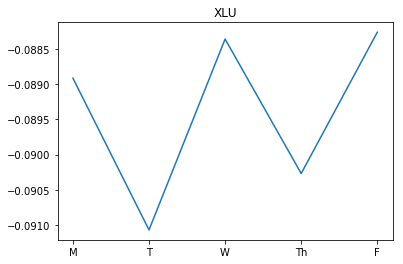

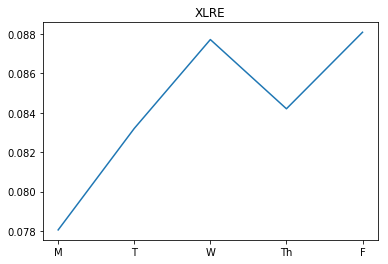

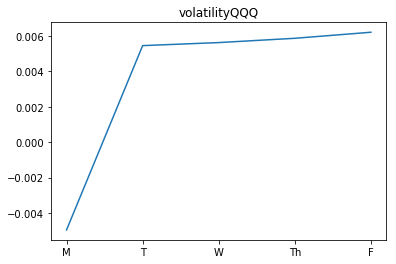

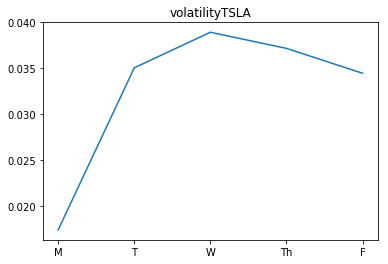

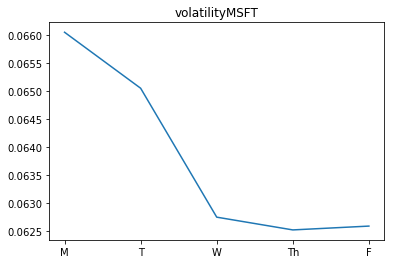

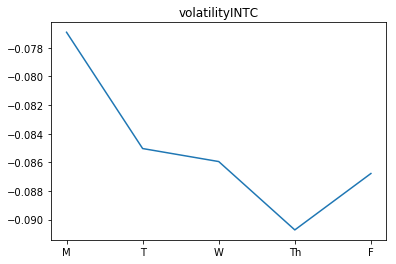

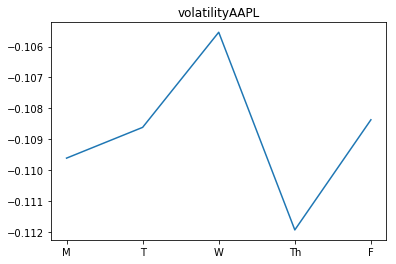

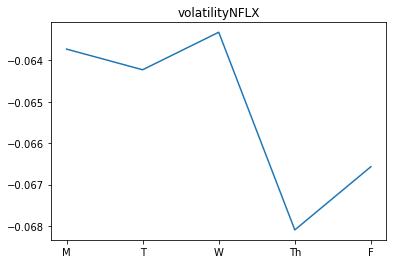

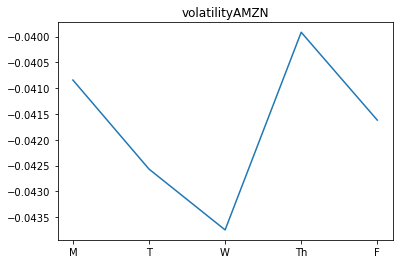

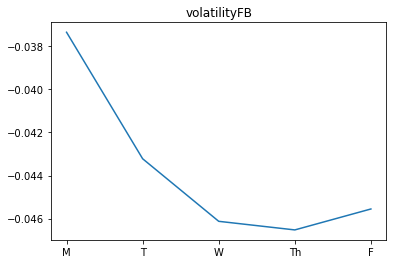

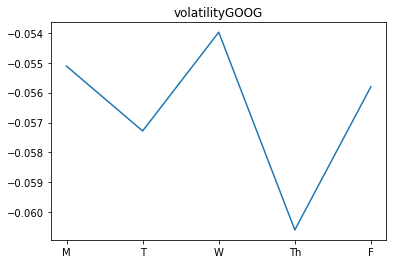

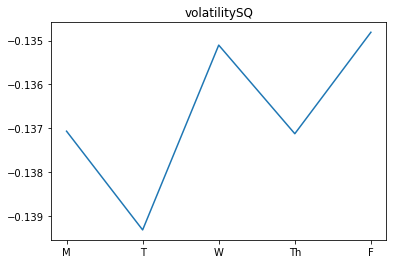

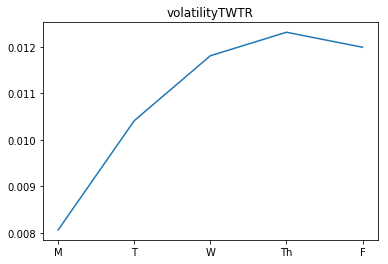

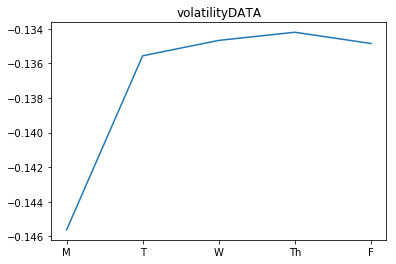

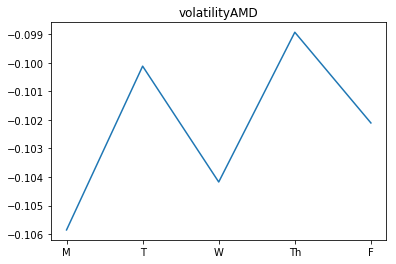

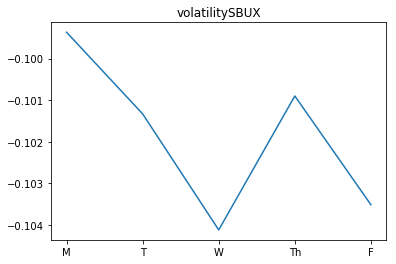

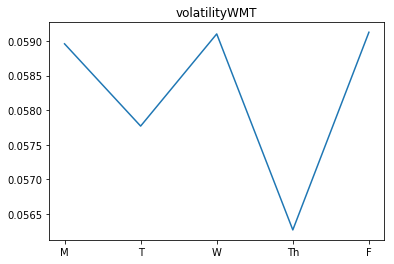

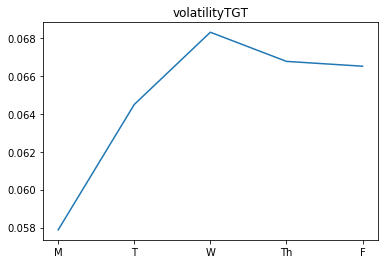

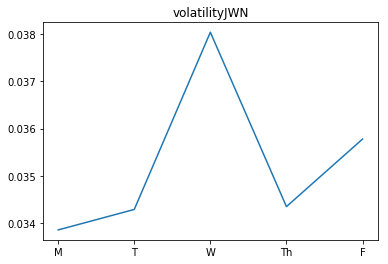

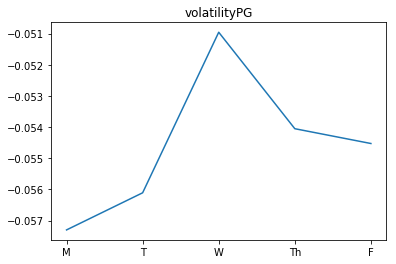

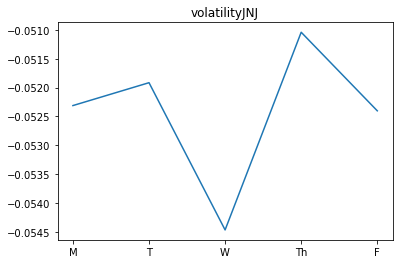

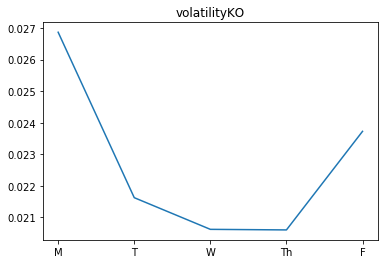

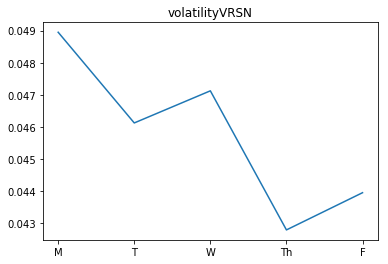

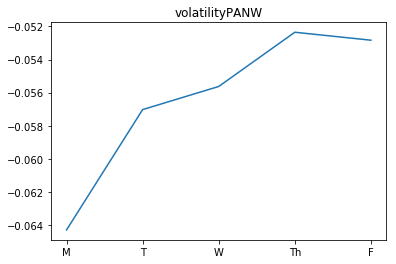

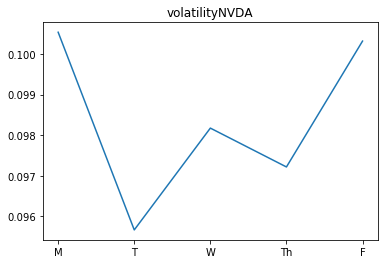

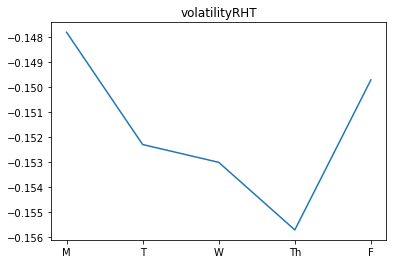

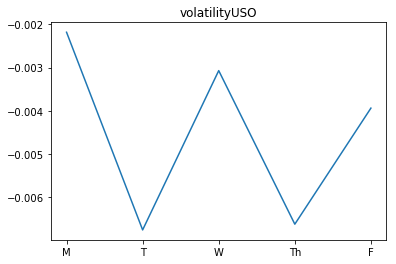

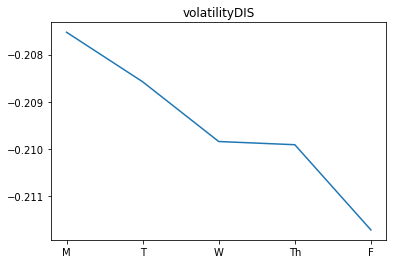

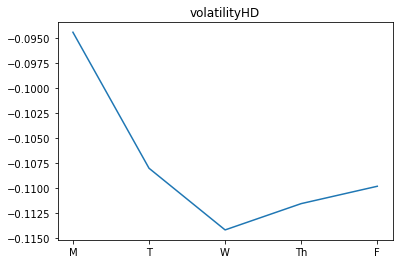

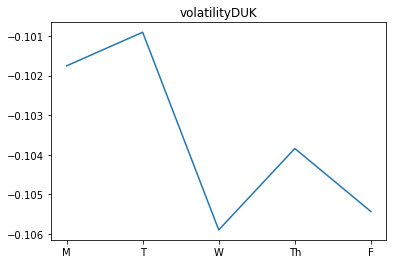

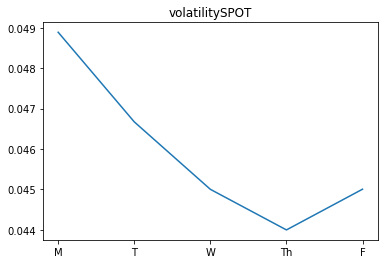

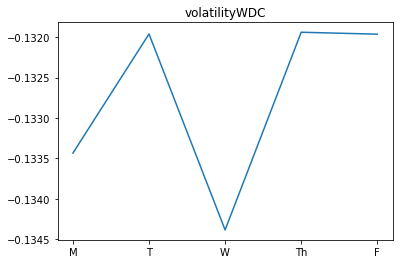

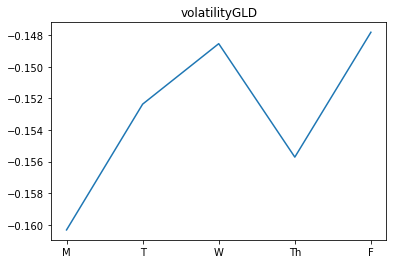

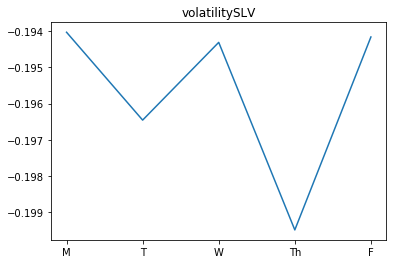

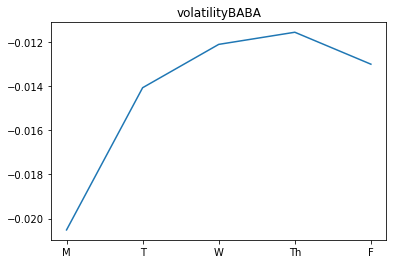

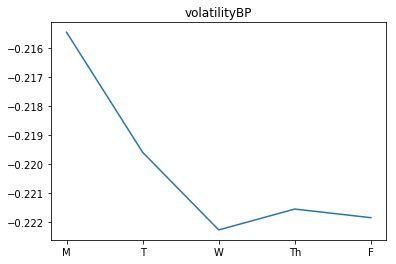

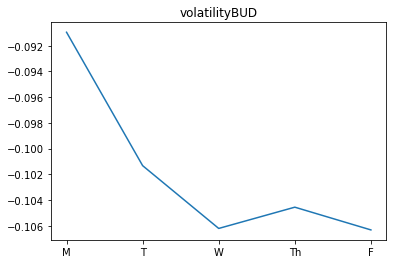

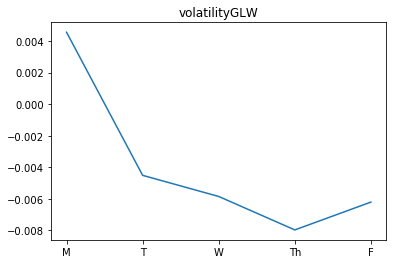

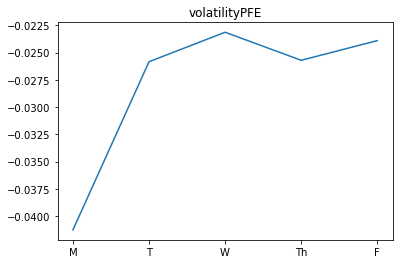

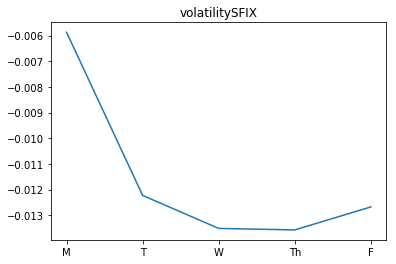

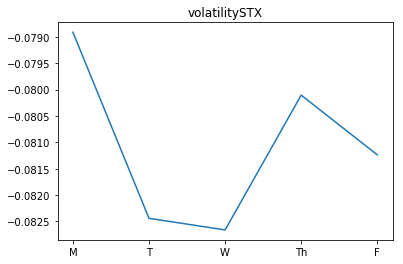

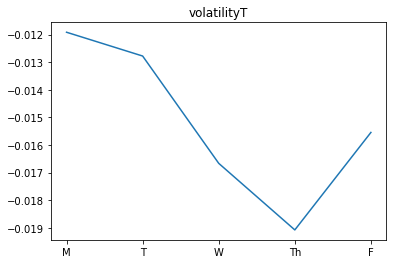

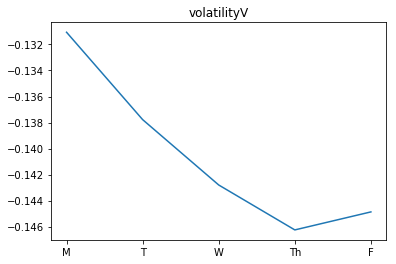

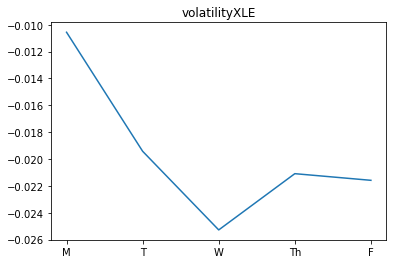

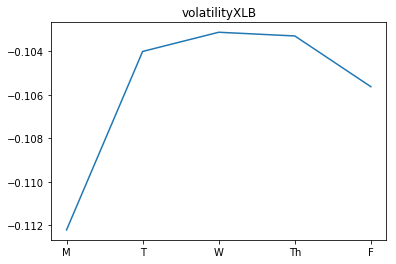

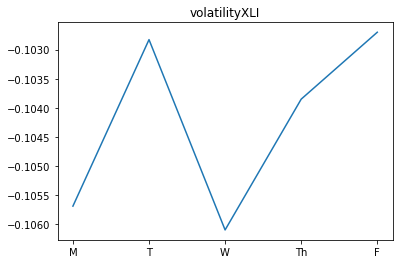

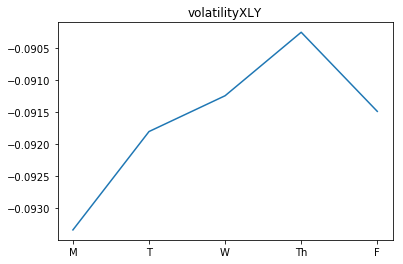

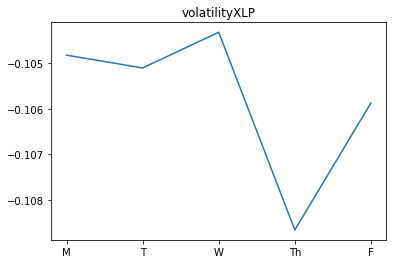

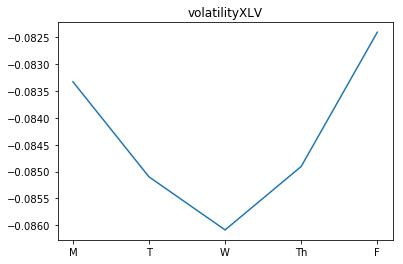

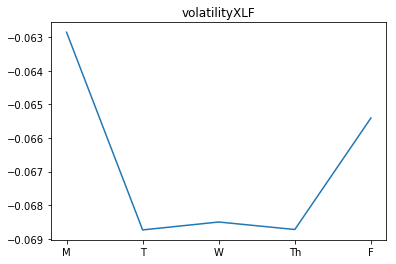

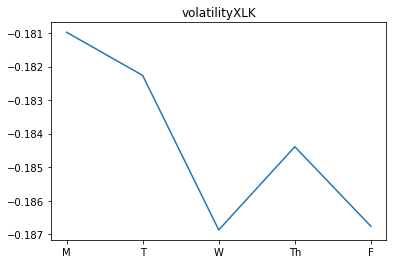

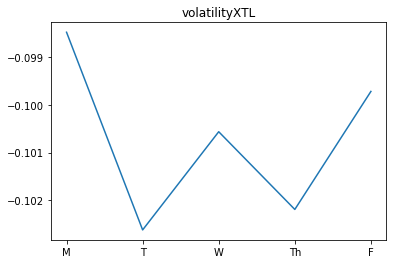

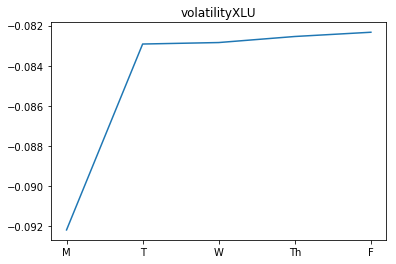

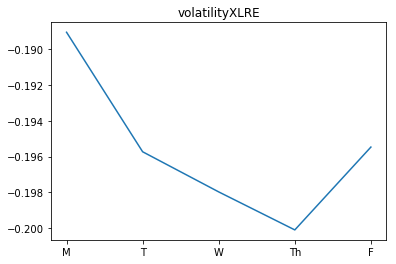

In [154]:
for t in list(ticker_lookup.keys()):
    plt.title(t)
    plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
    plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
    plt.show()

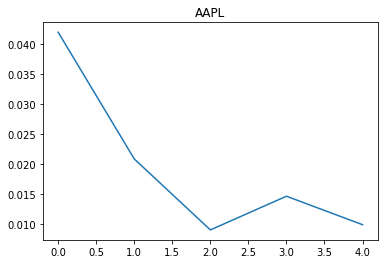

In [116]:
plt.title("AAPL")
plt.plot([i[ticker_lookup["AAPL"]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
plt.show()